In [1]:
!pip install yfinance textblob

In [64]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
# Download Apple stock data from Jan 2015 to Jan 2024
data = yf.download("AAPL", start="2015-01-01", end="2024-01-01")

# Shows the first 5 rows of data
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000
2015-01-06,23.606560,23.866485,23.244440,23.668764,263188400
2015-01-07,23.937572,24.037543,23.704305,23.815385,160423600
2015-01-08,24.857307,24.915069,24.148621,24.266367,237458000


In [66]:
print(data.columns)

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [68]:
# Calculated Simple Moving Averages
data[('SMA50', '')] = data['Close'].rolling(window=50).mean()
data[('SMA200', '')] = data['Close'].rolling(window=200).mean()


In [69]:
data.columns = [col[0] for col in data.columns]
print(data.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA50', 'SMA200'], dtype='object')


In [74]:
import numpy as np

# Function to calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Applied RSI function
data['RSI'] = calculate_rsi(data['Close'])

# Shows latest 10 rows with RSI
data[['Close', 'SMA50', 'SMA200', 'RSI']].tail(10)


,Close,SMA50,SMA200,RSI
Date,,,,
2023-12-15,196.133682,182.336478,175.893394,67.843986
2023-12-18,194.465897,182.706439,176.119092,62.002594
2023-12-19,195.508270,183.067505,176.336160,66.535547
2023-12-20,193.413605,183.398575,176.553778,59.991742
2023-12-21,193.264679,183.698707,176.764374,57.388241
2023-12-22,192.192551,183.959354,176.980881,59.246132
2023-12-26,191.646545,184.245961,177.204989,49.031926
2023-12-27,191.745819,184.537131,177.419855,52.291521
2023-12-28,192.172699,184.867970,177.626375,47.920452


In [77]:
# Creates a new column for Signal
data[('Signal', '')] = 0

# Buy: SMA50 > SMA200 and RSI < 70
data.loc[(data['SMA50'] > data['SMA200']) & (data['RSI'] < 70), 'Signal'] = 1

# Sell: SMA50 < SMA200 and RSI > 30
data.loc[(data['SMA50'] < data['SMA200']) & (data['RSI'] > 30), 'Signal'] = -1

# Shows the latest signals
data[['Close', 'SMA50', 'SMA200', 'RSI','Signal']].tail(25)

,Close,SMA50,SMA200,RSI,Signal
Date,,,,,
2023-11-24,188.588913,176.588258,172.636338,80.729352,0
2023-11-27,188.410217,176.886280,172.833685,77.463749,0
2023-11-28,189.015793,177.137722,173.032232,74.943919,0
2023-11-29,187.993286,177.346902,173.211626,69.049959,1
2023-11-30,188.569092,177.638583,173.397112,71.927771,0
2023-12-01,189.849701,177.986810,173.578472,66.351261,1
2023-12-04,188.052841,178.282047,173.758856,65.422933,1
2023-12-05,192.013855,178.630925,173.964779,68.276180,1
2023-12-06,190.921860,179.039657,174.185363,62.758984,1


In [78]:
capital = 10000
position = 0
buy_price = 0
pnl_list = []

for i in range(len(data)):
    signal = data['Signal'].iloc[i]
    close_price = data['Close'].iloc[i]

    # Buy logic
    if signal == 1 and position == 0:
        buy_price = close_price
        position = 1
        print(f"BUY at ₹{buy_price:.2f} on {data.index[i].date()}")

    # Sell logic
    elif signal == -1 and position == 1:
        sell_price = close_price
        profit = sell_price - buy_price
        capital += profit
        pnl_list.append(profit)
        position = 0
        print(f"SELL at ₹{sell_price:.2f} on {data.index[i].date()} → Profit: ₹{profit:.2f}")

# Optional: Sell at end if still holding
if position == 1:
    final_price = data['Close'].iloc[-1]
    profit = final_price - buy_price
    capital += profit
    pnl_list.append(profit)
    print(f"FORCED SELL at ₹{final_price:.2f} on {data.index[-1].date()} → Profit: ₹{profit:.2f}")

# Final output
print(f"\nFinal capital: ₹{capital:.2f}")
print(f"Total completed trades: {len(pnl_list)}")
print(f"Total Profit: ₹{sum(pnl_list):.2f}")


BUY at ₹24.36 on 2016-08-30
SELL at ₹37.44 on 2018-12-26 → Profit: ₹13.08
BUY at ₹49.87 on 2019-05-06
SELL at ₹143.08 on 2022-06-03 → Profit: ₹93.21
BUY at ₹148.60 on 2022-09-26
SELL at ₹138.07 on 2022-10-07 → Profit: ₹-10.53
BUY at ₹157.14 on 2023-03-23
FORCED SELL at ₹191.13 on 2023-12-29 → Profit: ₹33.99

Final capital: ₹10129.76
Total completed trades: 4
Total Profit: ₹129.76


In [43]:
print("BUY signals:", len(data[data['Signal'] == 1]))
print("SELL signals:", len(data[data['Signal'] == -1]))

BUY signals: 1187
SELL signals: 440


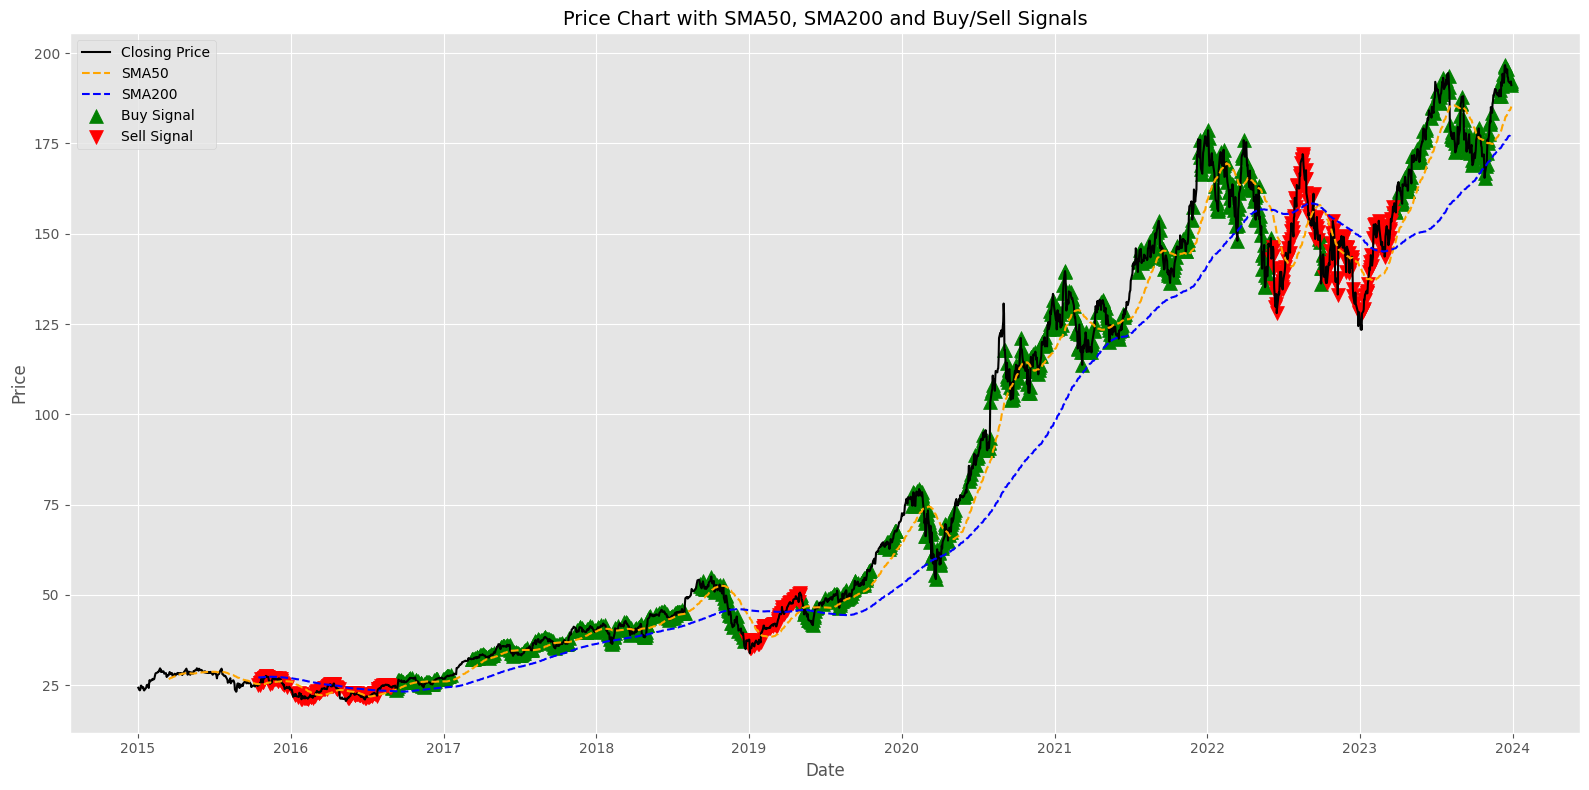

In [85]:
import matplotlib.pyplot as plt

# Sets up the figure
plt.figure(figsize=(16, 8))

# Plots closing price
plt.plot(data['Close'], label='Closing Price', color='black', linewidth=1.5)

# Plots SMA50 and SMA200
plt.plot(data['SMA50'], label='SMA50', linestyle='--', color='orange')
plt.plot(data['SMA200'], label='SMA200', linestyle='--', color='blue')

# Plots Buy signals
buy_signals = data[data['Signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)

# Plots Sell signals
sell_signals = data[data['Signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)

# Labels and legend
plt.title('Price Chart with SMA50, SMA200 and Buy/Sell Signals', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
